# DACON 월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
대회 링크 : [월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
](https://dacon.io/competitions/official/235713/overview/description)

## Column 설명 / Target에 대한 구상

### FEATURES

index  

gender: 성별  

car: 차량 소유 여부  

reality: 부동산 소유 여부  

child_num: 자녀 수  

income_total: 연간 소득  

income_type: 소득 분류 :  
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  
[세일즈(영업), 일반 직장, 공무원, 연금수령자, 학생]  
여기서 세일즈가 다른 이유 -> 월급 + 자신이 파는 것까지 버는 특이한 직업임

edu_type: 교육 수준  :  
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  
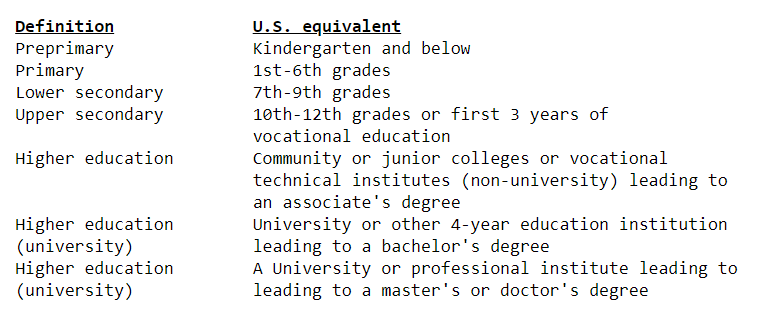  


family_type: 결혼 여부 :  
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

house_type: 생활 방식 :  
['Municipal apartment', 'House / apartment', 'With parents',  
'Co-op apartment', 'Rented apartment', 'Office apartment']

DAYS_BIRTH: 출생일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

DAYS_EMPLOYED: 업무 시작일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

양수 값은 고용되지 않은 상태를 의미함

FLAG_MOBIL: 핸드폰 소유 여부

work_phone: 업무용 전화 소유 여부

phone: 전화 소유 여부

email: 이메일 소유 여부

occyp_type : 직업 유형 -> 구분을 지을 수 있을까? ex) 연봉별  
										
family_size: 가족 규모

begin_month: 신용카드 발급 월  
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

---
### TARGET

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

---
### Target은 0, 1, 2 -> 분류 모델이 필요함 (Classification)

## RandomForest Version

## 0. Import & Reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, log_loss

# RandomForest, Catboost & Optunaf
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import optuna

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)

(26457, 20)


In [4]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [5]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


## 1. Basic EDA

칼럼을 보며
- `gender, car, reality` -> binary
- `income_total, DAYS~` -> num, cont.
- `family_size, child_num` -> 연관되어 있을 가능성이 높음
- `income_type, edu_type, family_type, house_type` -> cat. / str

In [6]:
sns.set_palette(sns.color_palette('Purples'))

Text(0.5, 1.0, 'Possesion of Real estate-Credit score countplot')

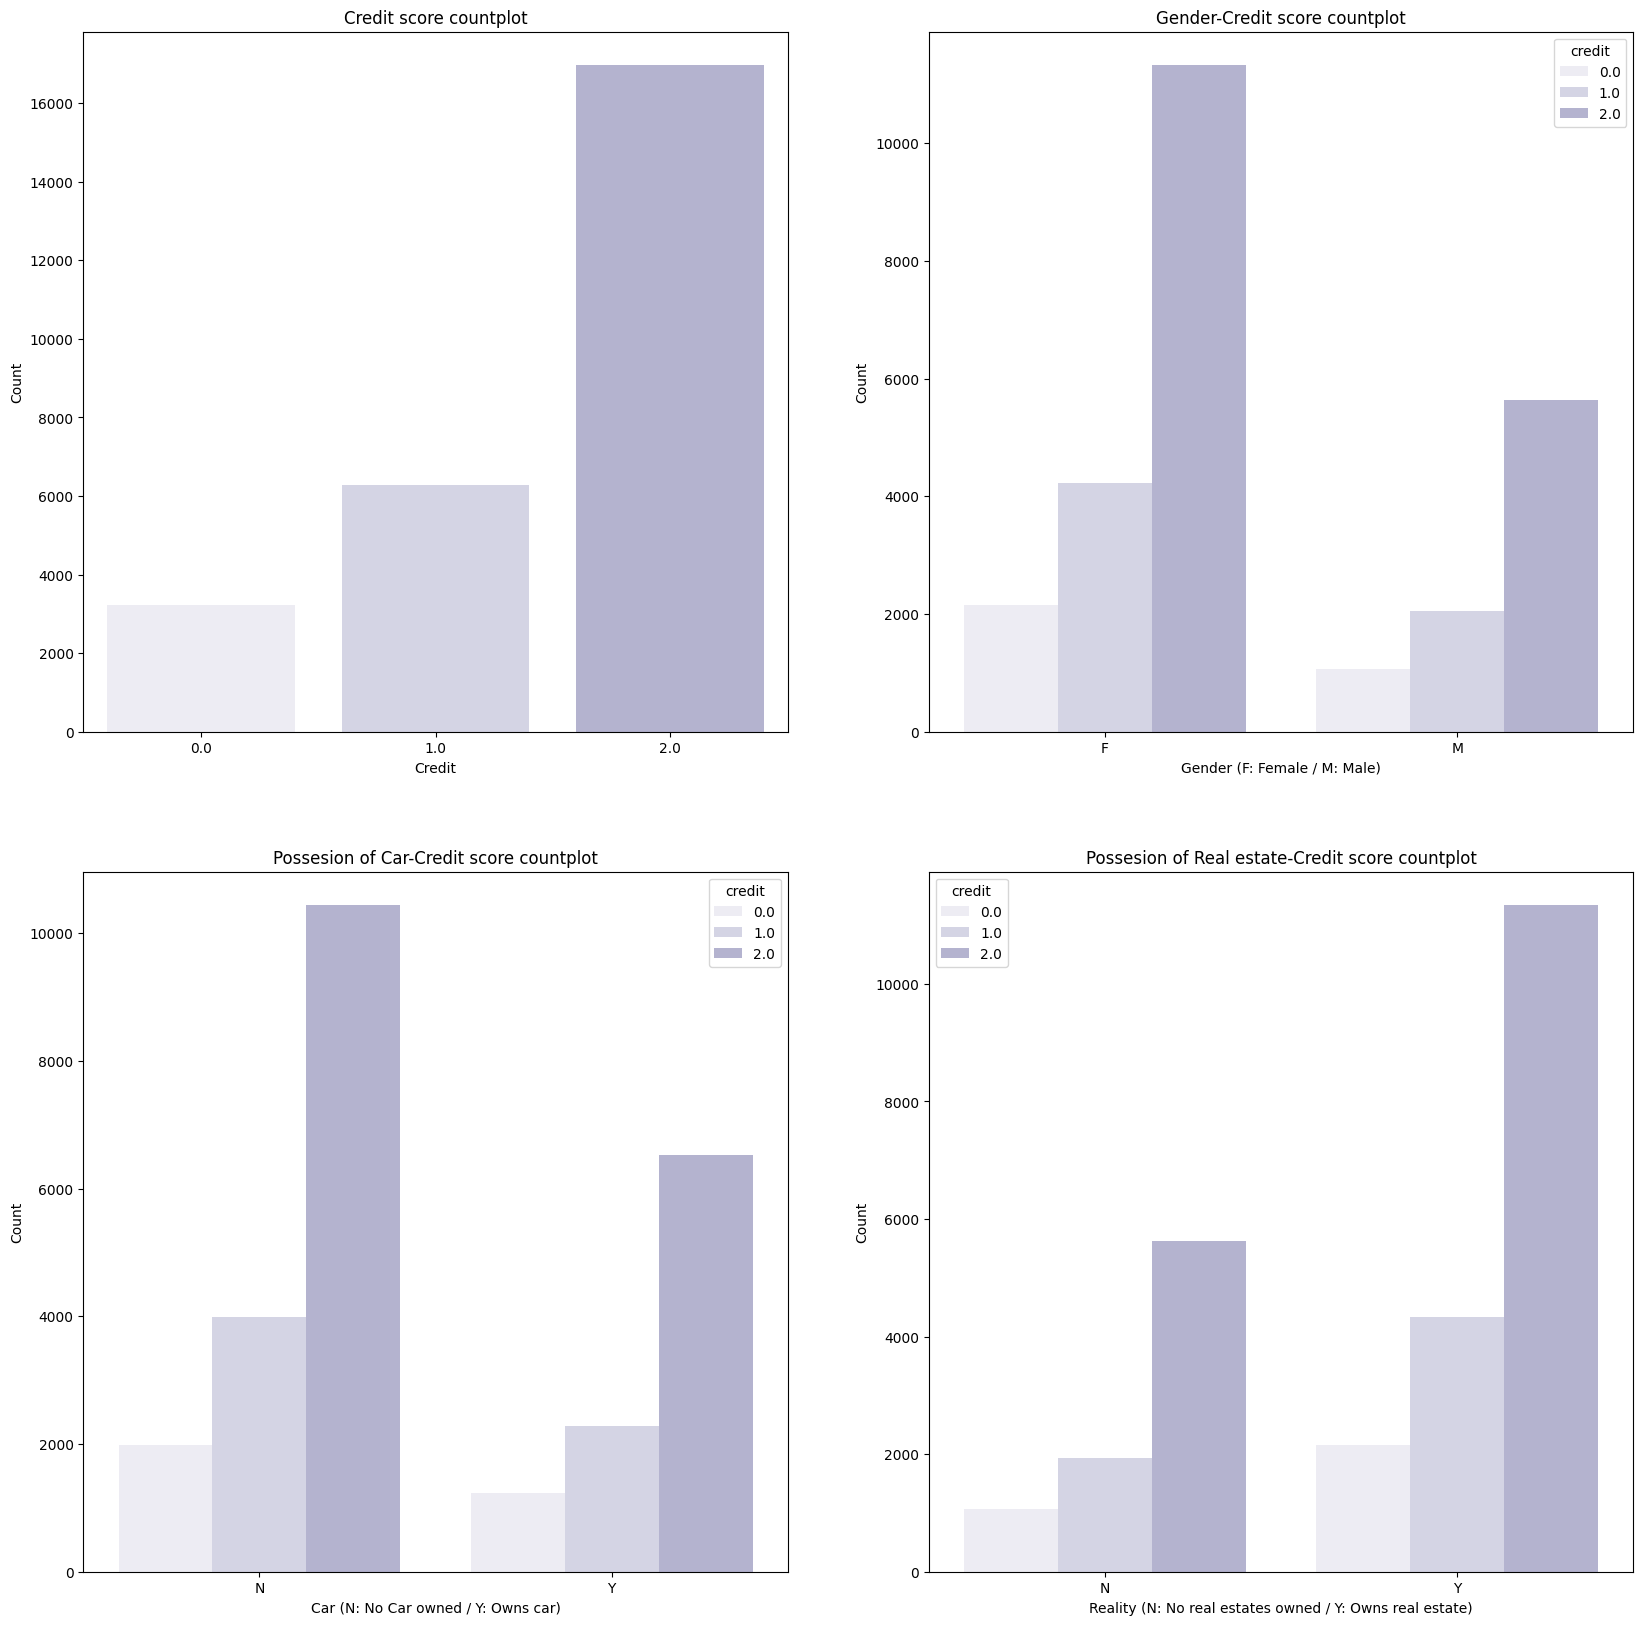

In [7]:
fig1, ax1 = plt.subplots(2, 2, figsize=(20, 20))

credit_count = sns.countplot(train, x='credit', ax=ax1[0,0])
credit_count.set_ylabel('Count')
credit_count.set_xlabel('Credit')
credit_count.set_title('Credit score countplot')

gender_count = sns.countplot(train, x='gender', hue='credit', ax=ax1[0,1])
gender_count.set_ylabel('Count')
gender_count.set_xlabel('Gender (F: Female / M: Male)')
gender_count.set_title('Gender-Credit score countplot')

car_count = sns.countplot(train, x='car', hue='credit', ax=ax1[1,0])
car_count.set_ylabel('Count')
car_count.set_xlabel('Car (N: No Car owned / Y: Owns car)')
car_count.set_title('Possesion of Car-Credit score countplot')

reality_count = sns.countplot(train, x='reality', hue='credit', ax=ax1[1,1])
reality_count.set_ylabel('Count')
reality_count.set_xlabel('Reality (N: No real estates owned / Y: Owns real estate)')
reality_count.set_title('Possesion of Real estate-Credit score countplot')

In [8]:
# communication 변수 생성
train['communication'] = 0

for col in ['phone','work_phone','email'] :
    train['communication'] += train[col]
    train = train.drop(col, axis=1)

train['communication'].unique()

array([0, 1, 3, 2], dtype=int64)

In [9]:
# test에도 communication 변수 생성
test['communication'] = 0

for col in ['phone','work_phone','email'] :
    test['communication'] += test[col]
    test = test.drop(col, axis=1)

Text(0.5, 1.0, 'Number of comm. methods-Credit score countplot')

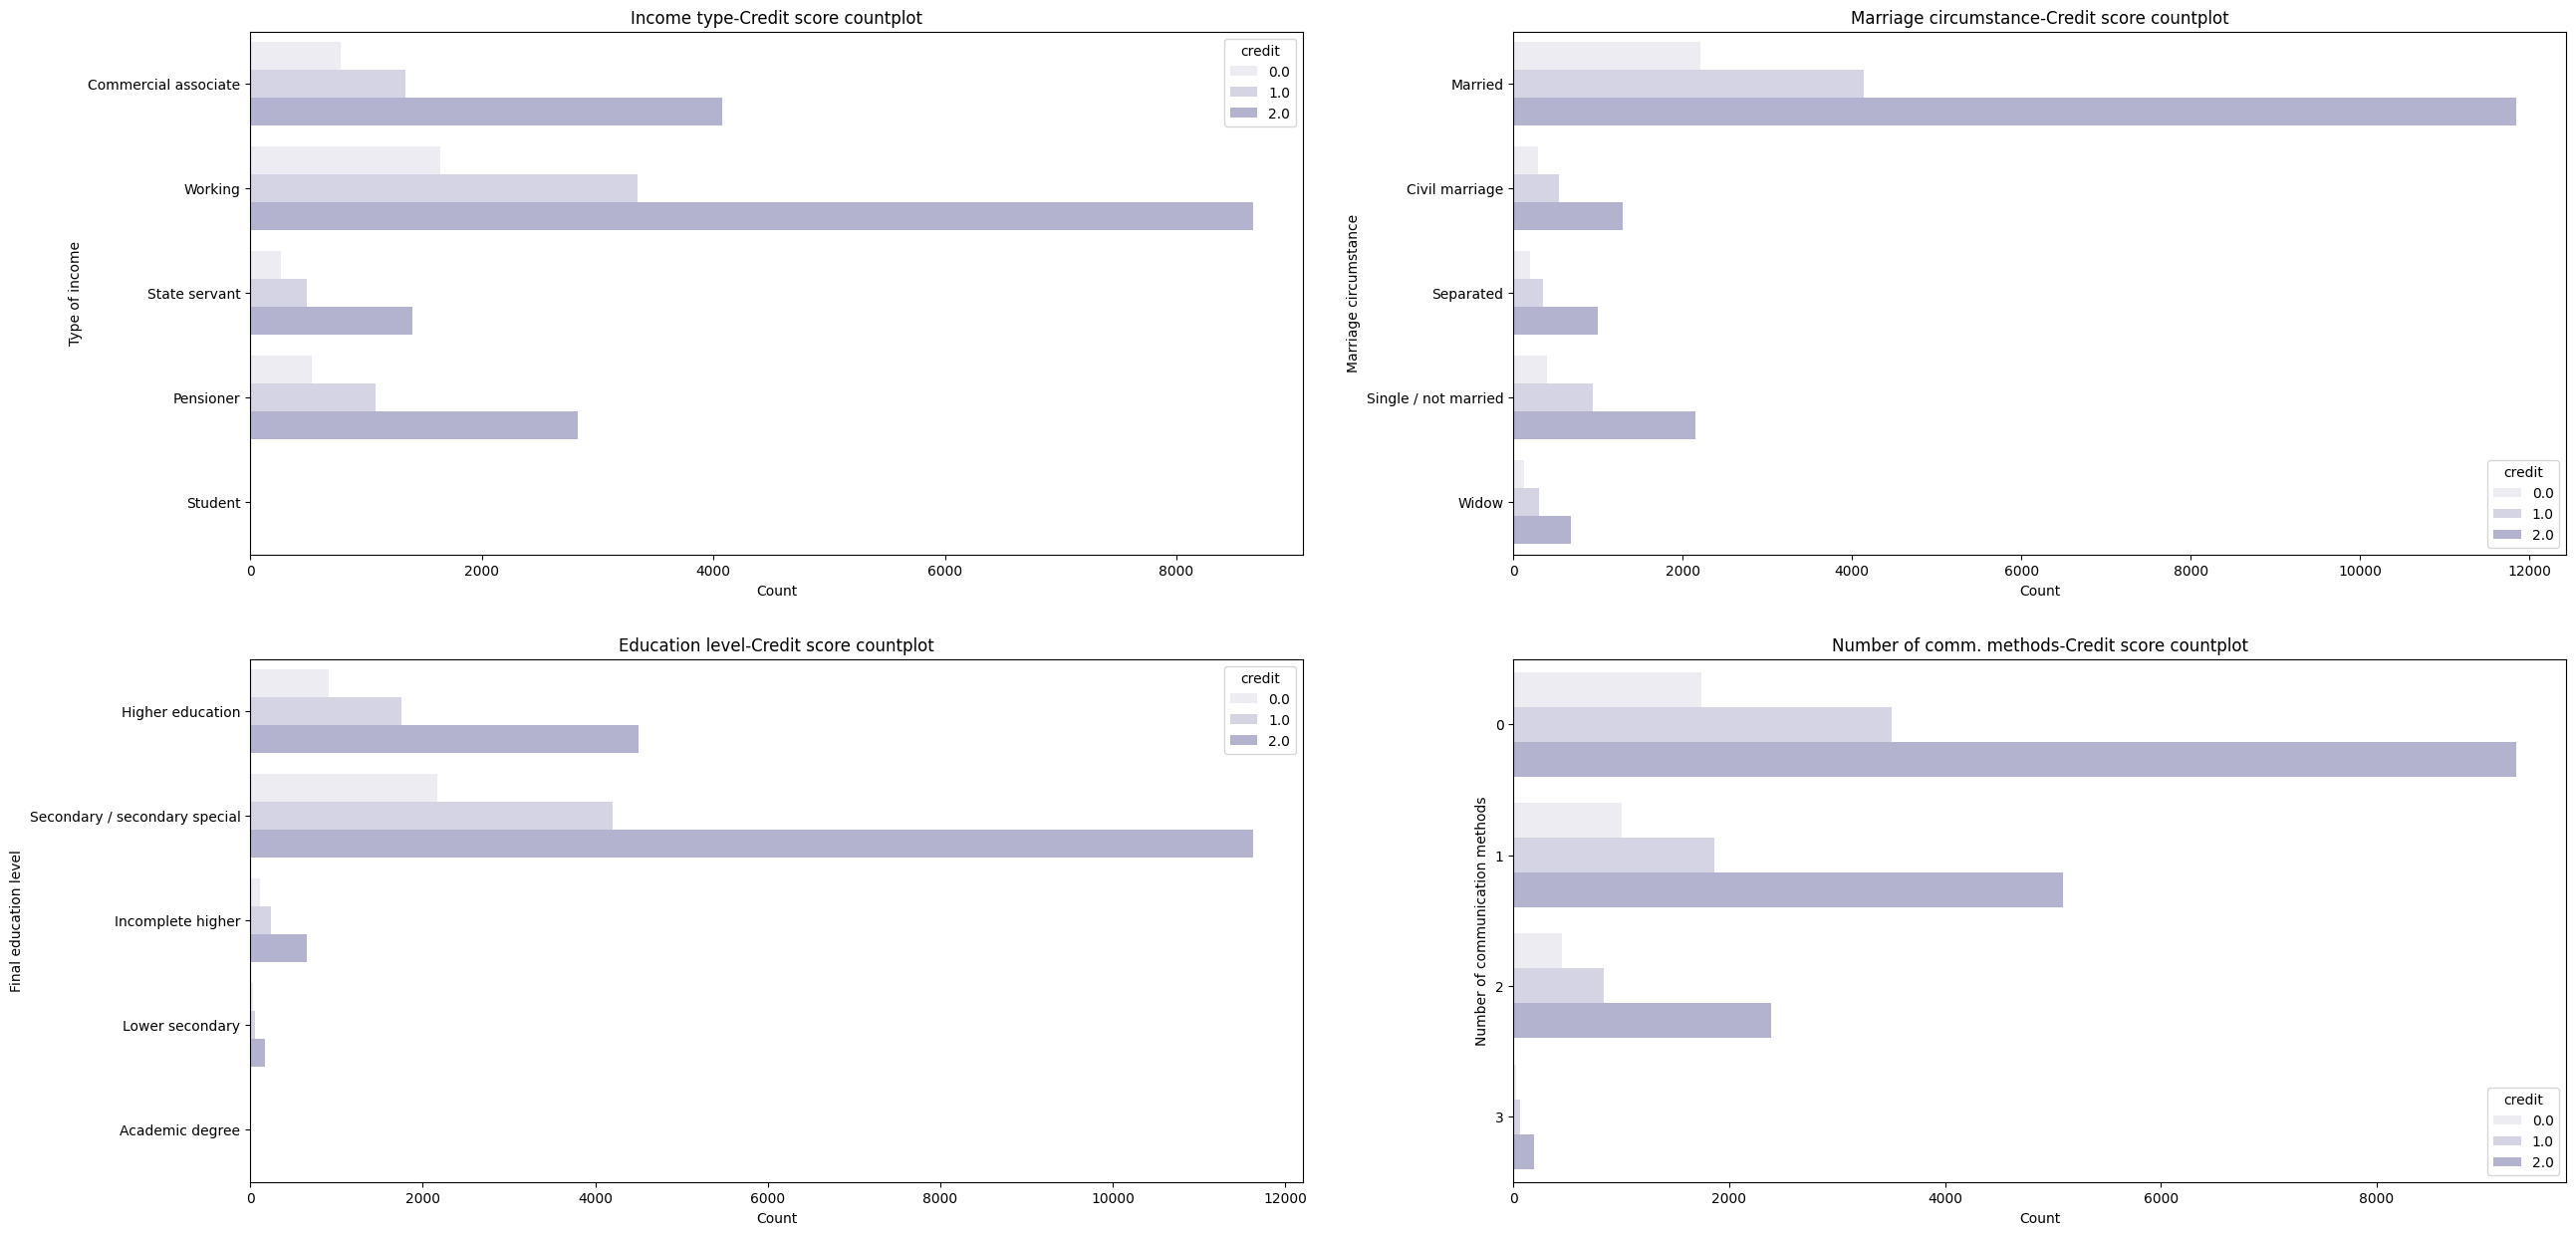

In [10]:
fig2, ax2 = plt.subplots(2, 2, figsize=(30, 15))

income_count = sns.countplot(train, y='income_type', hue='credit', ax=ax2[0,0])
income_count.set_ylabel('Type of income')
income_count.set_xlabel('Count')
income_count.set_title('Income type-Credit score countplot')

family_count = sns.countplot(train, y='family_type', hue='credit', ax=ax2[0,1])
family_count.set_ylabel('Marriage circumstance')
family_count.set_xlabel('Count')
family_count.set_title('Marriage circumstance-Credit score countplot')

edu_count = sns.countplot(train, y='edu_type', hue='credit', ax=ax2[1,0])
edu_count.set_ylabel('Final education level')
edu_count.set_xlabel('Count')
edu_count.set_title('Education level-Credit score countplot')

comm_count = sns.countplot(train, y='communication', hue='credit', ax=ax2[1,1])
comm_count.set_ylabel('Number of communication methods')
comm_count.set_xlabel('Count')
comm_count.set_title('Number of comm. methods-Credit score countplot')


<Axes: xlabel='child_num', ylabel='count'>

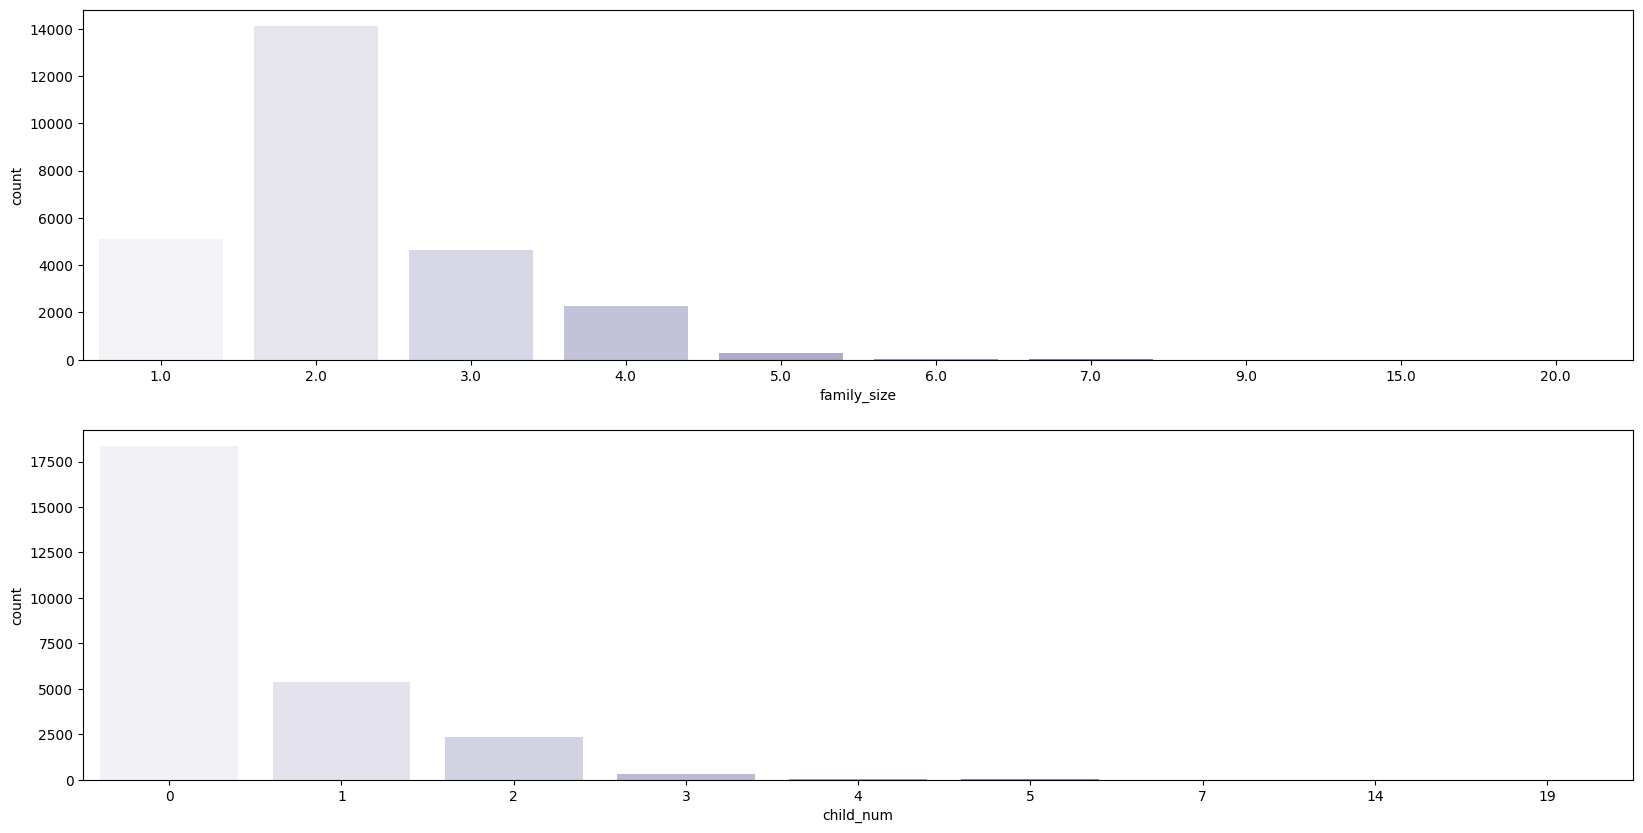

In [11]:
fig3, ax3 = plt.subplots(2, 1, figsize=(20, 10))

sns.countplot(train, x='family_size', ax=ax3[0], palette='Purples') # family_size가 5 이상이면 이상치
sns.countplot(train, x='child_num', ax=ax3[1], palette='Purples') # child_num이 3 이상이면 이상치

<Axes: title={'center': 'Income Total Histogram'}, xlabel='Income', ylabel='Count'>

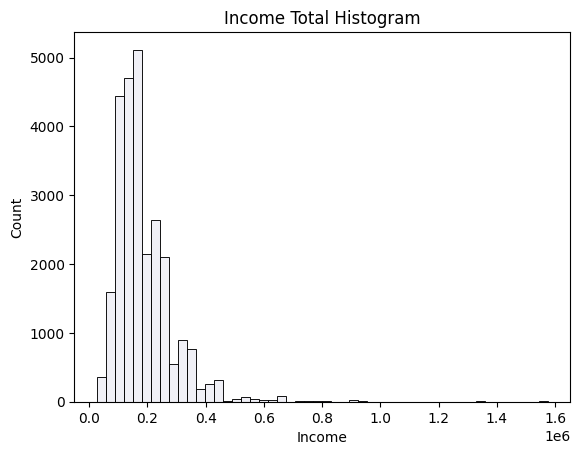

In [12]:
# income_total
plt.title("Income Total Histogram")
plt.xlabel('Income')
plt.ylabel('Count')
sns.histplot(train, x='income_total', bins=50) # right-skewed

Text(0.5, 1.0, 'Correlation plot')

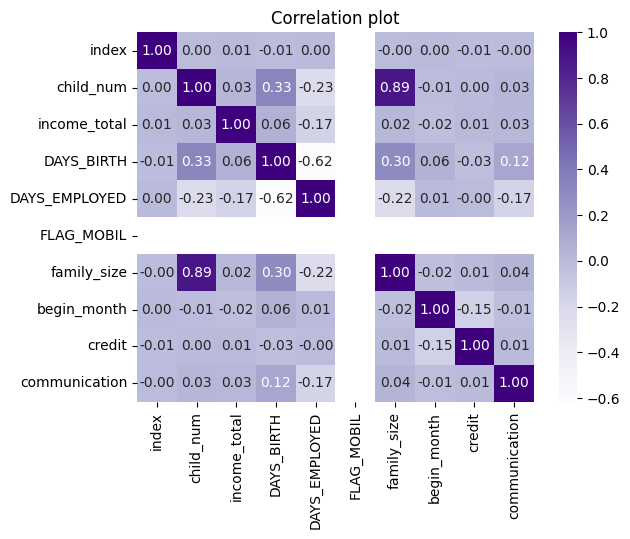

In [13]:
# 전반적인 corrplot
corr = train.corr()
sns.heatmap(corr, cmap='Purples', annot=True, fmt='.2f')
plt.title('Correlation plot')

## 3. Preprocesssing

~~index~~

### Before going in
A note from CatBoost doc:

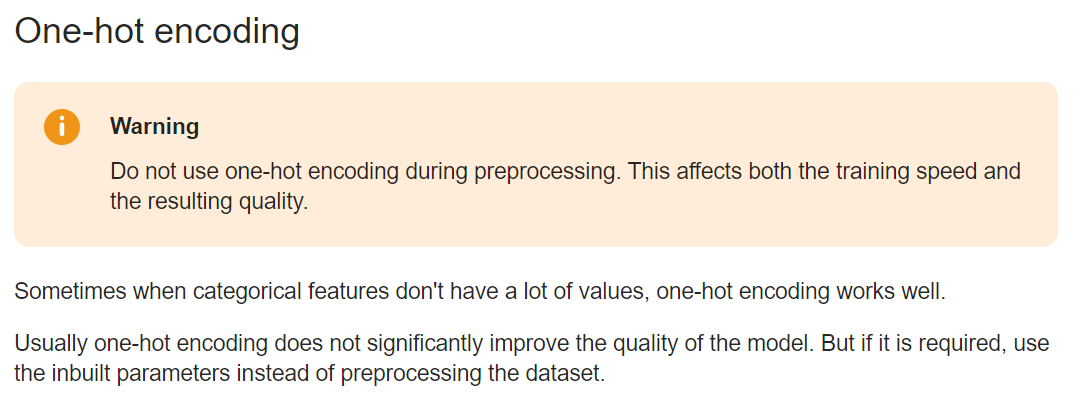

---

### Binary 변수 : 

gender: 성별  
car: 차량 소유 여부  
reality: 부동산 소유 여부  
#### -> CatBoost에서 범주형으로 처리하도록 함 (원래는 one-hot encoding을 진행하려했으나 위의 제약으로 인해 배제)

---

### 소득, 직업 관련 변수  

income_total: 연간 소득 

#### -> log transformation 필요 (right-skewed)


income_type: 소득 분류 :  
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  
[세일즈(영업), 일반 직장, 공무원, 연금수령자, 학생]  
여기서 세일즈가 다른 이유 -> 월급 + 자신이 파는 것까지 버는 특이한 직업임

edu_type: 교육 수준  :  
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  
family_type: 결혼 여부 :  
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

house_type: 생활 방식 :  
['Municipal apartment', 'House / apartment', 'With parents',  
'Co-op apartment', 'Rented apartment', 'Office apartment']

occyp_type : 직업 유형
#### -> 전부 Catboost 모델에서 범주형으로 처리토록 함

---

### 날짜 관련 변수

DAYS_EMPLOYED: 업무 시작일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미  
양수 값은 고용되지 않은 상태를 의미함
#### -> 근무기간을 년 단위로 파생변수 생성

DAYS_BIRTH: 출생일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
#### -> 나이로 파생변수 생성

begin_month: 신용카드 발급 월  
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미  


~~FLAG_MOBIL: 핸드폰 소유 여부~~

---

### 통신 관련 Binary 변수 : communication으로 통합 (위에서 이미 진행)

work_phone: 업무용 전화 소유 여부  
phone: 전화 소유 여부  
email: 이메일 소유 여부

---

### 가정 관련 변수
family_size: 가족 규모
child_num: 자녀 수  
#### -> 파생변수 생성? PCA?

---

In [14]:
# 불필요 변수 제거
train.drop(['index','FLAG_MOBIL'], inplace=True, axis=1)
test.drop(['index','FLAG_MOBIL'], inplace=True, axis=1)

In [15]:
# income_total 로그 변환
train['income_total'] = np.log(train['income_total'])
test['income_total'] = np.log(test['income_total'])

<Axes: xlabel='income_total', ylabel='Count'>

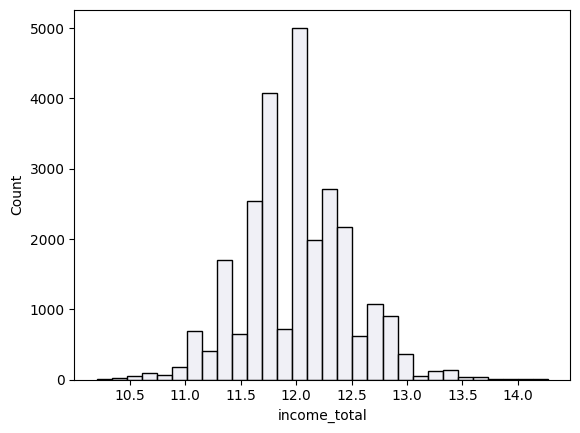

In [16]:
# income_total 확인
sns.histplot(train, x='income_total', bins=30, palette='Purples') # 나름대로 균일한 분포를 이룸

In [17]:
# DAYS_EMPLOYED - 0 이상은 전부 무직이므로 0으로 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [18]:
# DAYS_BIRTH, DAYS_EMPLOYED, begin_month 모두 현시점으로 역행이 아니라
# 해당 시점에서 현재까지의 시간을 나타내기 위해 양수로 처리

# DAYS_BIRTH 모두 양수로 변환
train['DAYS_BIRTH'] = np.abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = np.abs(test['DAYS_BIRTH'])

# DAYS_EMPLOYED 모두 양수로 변환
train['DAYS_EMPLOYED'] = np.abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = np.abs(test['DAYS_EMPLOYED'])

# begin_month 모두 양수로 변환
train['begin_month'] = np.abs(train['begin_month'])
test['begin_month'] = np.abs(test['begin_month'])

In [19]:
# 현시점 나이를 년, 월, 주 단위로 age_ 변수 설정
train['age_y'] = train['DAYS_BIRTH'] // 365
test['age_y'] = test['DAYS_BIRTH'] // 365
train['age_m'] = train['DAYS_BIRTH'] % 365 // 30
test['age_m'] = test['DAYS_BIRTH'] % 365 // 30
train['age_w'] = train['DAYS_BIRTH'] % 365 % 30 // 7
test['age_w'] = test['DAYS_BIRTH'] % 365 % 30 // 7

In [20]:
# 근무 기간 (년, 월, 일) working_ 변수로 설정
train['working_y'] = train['DAYS_EMPLOYED'] // 365
test['working_y'] = test['DAYS_EMPLOYED'] // 365
train['working_m'] = train['DAYS_EMPLOYED'] % 365 // 30
test['working_m'] = test['DAYS_EMPLOYED'] % 365 // 30
train['working_w'] = train['DAYS_EMPLOYED'] % 365 % 30 // 7
test['working_w'] = test['DAYS_EMPLOYED'] % 365 % 30 // 7

In [21]:
# 결측치 확인
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
occyp_type       8171
family_size         0
begin_month         0
credit              0
communication       0
age_y               0
age_m               0
age_w               0
working_y           0
working_m           0
working_w           0
dtype: int64

In [22]:
test.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
occyp_type       3152
family_size         0
begin_month         0
communication       0
age_y               0
age_m               0
age_w               0
working_y           0
working_m           0
working_w           0
dtype: int64

In [23]:
# 결측치 NaN으로 처리
train.fillna("NaN",inplace=True)
test.fillna("NaN",inplace=True)

In [24]:
# DAYS_EMPLOYED가 0이고 occyp_type이 None이면 무직자
# DAYS_EMPLOYED가 0이 아니고 occyp_type이 None이면 결측치
train.loc[((train['DAYS_EMPLOYED']== 0) & (train['occyp_type'] == "NaN")),'occyp_type'] = 'No_Job'
test.loc[((test['DAYS_EMPLOYED']== 0) & (test['occyp_type'] == "NaN")),'occyp_type'] = 'No_Job'

In [25]:
train.loc[train['occyp_type']=='NaN']

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,communication,age_y,age_m,age_w,working_y,working_m,working_w
0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,13899,...,2.0,6.0,1.0,0,38,0,4,12,10,4
8,M,Y,Y,1,12.100712,Commercial associate,Higher education,Married,House / apartment,15131,...,3.0,38.0,2.0,1,41,5,2,4,0,0
19,F,N,Y,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,13727,...,2.0,7.0,2.0,0,37,7,1,16,6,1
20,M,N,N,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,19850,...,2.0,35.0,2.0,1,54,4,2,4,9,3
23,M,Y,N,0,12.323856,Working,Secondary / secondary special,Married,Municipal apartment,14542,...,2.0,18.0,2.0,3,39,10,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26433,F,Y,N,0,11.707670,State servant,Higher education,Married,House / apartment,19912,...,2.0,31.0,2.0,1,54,6,3,13,7,2
26435,F,N,N,1,11.744037,Working,Secondary / secondary special,Widow,House / apartment,19691,...,2.0,40.0,2.0,0,53,11,2,1,3,2
26437,M,N,Y,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,13015,...,2.0,13.0,2.0,0,35,8,0,9,12,0
26449,F,N,N,0,11.407565,Working,Secondary / secondary special,Married,House / apartment,10498,...,2.0,2.0,1.0,2,28,9,1,6,7,2


In [26]:
len(train.loc[train['occyp_type']=='NaN']) / len(train) # 데이터의 약 14%에서 occupation 미확인

0.14109687417318667

`NaN`을 어떻게 처리할 것인가?
1. `NaN` 삭제하기
2. `NaN`을 다른 방식으로 처리하기 -> 직업에 대한 세부 사항을 알 수 있는가? -> 생각나는게 없음

In [27]:
train.drop(train.index[train['occyp_type'] == 'NaN'], inplace=True)

In [29]:
# family size & child num
# Outlier 제거
train = train.loc[(train['family_size'] <= 5)] 
train = train.loc[(train['child_num'] <= 2)]

In [30]:
# 파생변수를 만든다면?
# train1 = train
# test1 = test
# train1['family'] = train['family_size'] + train['child_num']
# test1['family'] = test['family_size'] + train['child_num']

In [31]:
# PCA
pca = PCA(n_components=1).fit(train.loc[:, ['family_size', 'child_num']])
train['family_PCA'] = pca.transform(train.loc[:, ['family_size', 'child_num']])
train.drop(columns= ['family_size', 'child_num'], axis=1, inplace=True)

pca = PCA(n_components=1).fit(test.loc[:, ['family_size', 'child_num']])
test['family_PCA'] = pca.transform(test.loc[:, ['family_size', 'child_num']])
test.drop(columns= ['family_size', 'child_num'], axis=1, inplace=True)

In [34]:
# DAYS_BIRTH와 DAYS_EMPLOYED drop
train.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)
test.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

## 4. Modeling - CatBoost

In [35]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,begin_month,credit,communication,age_y,age_m,age_w,working_y,working_m,working_w,family_PCA
1,F,N,Y,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Laborers,5.0,1.0,1,31,2,0,4,2,2,1.058612
2,M,Y,Y,13.017003,Working,Higher education,Married,House / apartment,Managers,22.0,2.0,1,52,3,2,12,1,3,-0.340583
3,F,N,Y,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,37.0,0.0,1,41,4,0,5,8,3,-0.340583
4,F,Y,Y,11.967181,State servant,Higher education,Married,House / apartment,Managers,26.0,2.0,0,41,2,1,5,9,1,-0.340583
5,F,N,Y,12.506177,Working,Secondary / secondary special,Married,House / apartment,High skill tech staff,18.0,1.0,1,36,9,0,13,8,1,2.457806


In [36]:
test.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,begin_month,communication,age_y,age_m,age_w,working_y,working_m,working_w,family_PCA
0,M,Y,N,11.630709,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,No_Job,60.0,1,60,3,0,0,0,0,-0.428573
1,F,N,Y,11.813030,State servant,Higher education,Married,House / apartment,Core staff,36.0,1,51,11,2,23,9,0,-0.428573
2,F,N,Y,11.147239,Working,Secondary / secondary special,Married,House / apartment,Laborers,40.0,2,43,6,1,0,7,1,-0.428573
3,M,Y,N,11.630709,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,41.0,1,52,9,2,6,11,1,-0.428573
4,F,Y,Y,12.323856,State servant,Higher education,Married,House / apartment,Managers,8.0,1,48,10,0,25,8,2,-0.428573


In [37]:
train_x = train.drop(['credit'], axis=1)
train_y = train['credit']

In [38]:
# CatBoost model에 categorical var. 전달
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
[0 1 2 4 5 6 7 8]


In [814]:
# cat_models={}

# def cat_kfold(max_depth, learning_rate, random_seed):
    
#     folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
#     outcomes=[]
#     sub=np.zeros((test.shape[0], 3))  
    
#     for seed in random_seed:
#         for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
#             print(f'===================================={n_fold+1}============================================')
            
#             X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
#             y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

#             # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
#             cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
#             cat.fit(X_train, y_train,
#                   eval_set=[(X_train, y_train), (X_val, y_val)],
#                   early_stopping_rounds=50, cat_features=cat_features,
#                   verbose=100)

#             cat_models[n_fold] = cat

#             # val 데이터 예측
#             predictions = cat.predict_proba(X_val)
#             # test 데이터 예측
#             test_predictions = cat.predict_proba(test)

#             # val 데이터 예측 logloss 값 저장
#             logloss=log_loss(to_categorical(y_val), predictions)
#             outcomes.append(logloss)
#             print(f"FOLD {n_fold+1} : logloss:{logloss}")

#             # test 데이터 예측 결과 종합
#             # 최종 적으로는 kolds 횟수 만큼 나눠서 평균 값을 활용
#             sub+=test_predictions

#             print(f'================================================================================\n\n')

#     # 저장된 val 데이터 예측 logloss 값의 평균 값으로 성능을 비교
#     mean_outcome=np.mean(outcomes)
#     print("Mean:{}".format(mean_outcome))
    
#     return sub/(folds.n_splits * len(random_seed))

참고

https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna

In [39]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.20, random_state=10)

In [40]:
cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=100, learning_rate=0.04, bootstrap_type ='Bernoulli')
cat.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50, cat_features = cat_features, verbose=100)

0:	learn: 1.0759931	test: 1.0759931	test1: 1.0767594	best: 1.0767594 (0)	total: 234ms	remaining: 11m 41s
100:	learn: 0.7972382	test: 0.8001118	test1: 0.8146718	best: 0.8146718 (100)	total: 6.96s	remaining: 3m 19s
200:	learn: 0.7749665	test: 0.7840746	test1: 0.8054859	best: 0.8054859 (200)	total: 15.5s	remaining: 3m 35s
300:	learn: 0.7474409	test: 0.7635675	test1: 0.7958892	best: 0.7958892 (300)	total: 25.4s	remaining: 3m 47s
400:	learn: 0.7118255	test: 0.7320778	test1: 0.7820241	best: 0.7820241 (400)	total: 36.9s	remaining: 3m 58s
500:	learn: 0.6818217	test: 0.7070088	test1: 0.7724657	best: 0.7724657 (500)	total: 49s	remaining: 4m 4s
600:	learn: 0.6540540	test: 0.6845246	test1: 0.7639644	best: 0.7639644 (600)	total: 1m	remaining: 4m
700:	learn: 0.6299895	test: 0.6655537	test1: 0.7582346	best: 0.7582346 (700)	total: 1m 9s	remaining: 3m 49s
800:	learn: 0.6077843	test: 0.6492060	test1: 0.7539380	best: 0.7539380 (800)	total: 1m 19s	remaining: 3m 38s
900:	learn: 0.5863359	test: 0.6325335	te

In [ ]:
# optuna tuning for CatBoost

def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
# Create study
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [ ]:
# Eval
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
print(accuracy_score(y_test, y_pred))